# Laboratory work 4: least squares and interpolation

---

## Work objective:

Given the population of the USA from 1910 to 2000 every 10 years:

1) approximate it using the method of least squares;
2) build Newton's divided differences interpolation polynomial;
3) build a spline.

Then extrapolate the data to the year 2010 and compare the result with the actual data.

## Population

|Year | The number of citizens|
|:---:|:---------------------:|
|1910 | 92 228 496            |
|1920 |106 021 537            |
|1930 |123 202 624            |
|1940 |132 164 569            |
|1950 |151 325 798            |
|1960 |179 323 175            |
|1970 |203 211 926            |
|1980 |226 545 805            |
|1990 |248 709 873            |
|2000 |281 421 906            |
|2010 |308 745 538            |

---

## Input data

In [124]:
import numpy as np
from matplotlib import pyplot as plt

years = np.arange(1910, 2010, 10)
souls = np.array([92228496,
                  106021537,
                  123202624,
                  132164569,
                  151325798,
                  179323175,
                  203211926,
                  226545805,
                  248709873,
                  281421906])

souls_2010 = 308745538

## The method of least squares

In [125]:
def compute_least_squares_matrix(x, deg):

    arr = np.zeros(2 * deg + 1)

    n = len(x)
    arr[0] = n
    for i in range(1, 2 * deg + 1):
        for k in range(n):
            arr[i] += pow(x[k], i)

    A = np.empty([deg + 1, deg + 1])

    for i in range(deg + 1):
        for j in range(deg + 1):
            A[i, j] = arr[i + j]

    return A

def compute_free_coeffs_column(x, y, deg):

    b = np.zeros(deg + 1)

    n = len(x)
    b[0] = np.sum(y)
    for i in range(1, deg + 1):
        for k in range(n):
            b[i] += pow(x[k], i) * y[k]

    return b

class Least_Squares:

    def __init__(self, x, y, deg):

        if len(x) != len(y):
            raise RuntimeError("Input arrays must be of the same size")
        elif len(x) < deg + 1:
            raise RuntimeError(f"Not enough data to be approximated by polynomial of degree {deg}")

        A = compute_least_squares_matrix(x, deg)
        b = compute_free_coeffs_column(x, y, deg)

        self.coeffs = np.linalg.inv(A) @ b

    def __call__(self, x_0):
        return sum(self.coeffs[i] * (x_0**i) for i in range(len(self.coeffs)))

def least_squares_residual(x, y, deg):
    P = Least_Squares(x, y, deg)
    return np.sqrt(sum((y[i] - P(x[i]))**2 for i in range(len(x))) / (len(x) - 1))

Let's start by choosing the degree of a polynomial to approximate given data.

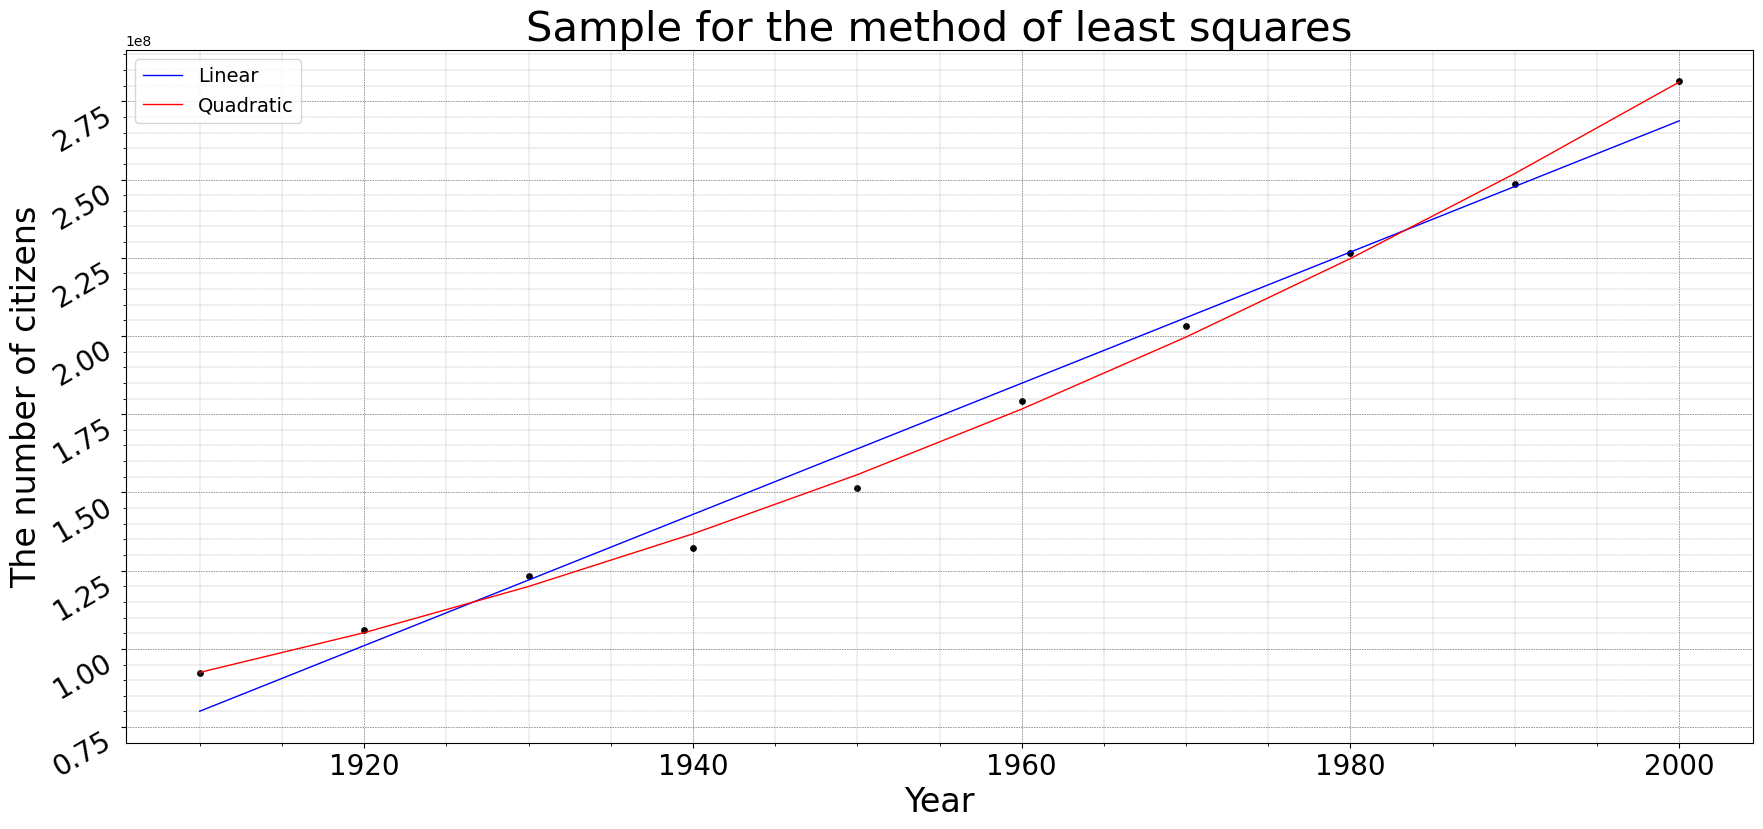

In [126]:
plt.figure(figsize = (21, 9), dpi = 100)
plt.title("Sample for the method of least squares", fontsize = 30)

plt.xlabel("Year", fontsize = 24)
plt.xticks(fontsize =  20, ha = "center", va = "top")

plt.ylabel("The number of citizens", fontsize = 24)
plt.yticks(fontsize = 20, rotation = 30, ha = "right", va = "top")

plt.scatter(years, souls, s = 15, color = "black")

linear_polynomial = Least_Squares(years, souls, 1)
plt.plot(years, linear_polynomial(years), color='blue', linewidth = 1, label = "Linear")

quadratic_polynomial = Least_Squares(years, souls, 2)
plt.plot(years, quadratic_polynomial(years), color='red', linewidth = 1, label = "Quadratic")

plt.legend(loc = "best", fontsize = 14)

plt.grid (color = "black", linewidth = 0.45, linestyle = "dotted")
plt.minorticks_on()
plt.grid (which = "minor", color = "grey", linewidth = 0.25, linestyle = "dashed")

plt.show()

Quadratic polynomial looks like it fits the data better. Let's check residuals of approximation for
both polynomials:

In [127]:
print(f"Linear residual: {least_squares_residual(years, souls, 1)}")
print(f"Quadratic residual: {least_squares_residual(years, souls, 2)}")

Linear residual: 8492402.153930673
Quadratic residual: 3071796.8858852186


We see that the residual of quadratic approximation is less than the one of the linear approximation.
Let's also take a look on the residual of a polynomial of degree 3:

In [128]:
print(f"Cubic residual: {least_squares_residual(years, souls, 3)}")

Cubic residual: 3071796.8858893835


It is the same as the residual of quadratic approximation to 6 decimal places. So we prefer
quadratic approximation because it's easier to calculate and provides us with basically the same
result.

Extrapolation of the quadratic polynomial to the year 2010 gives the following result:

In [129]:
ls_souls_2010 = round(quadratic_polynomial(2010))
# "ls" stands for "least squares"

print(f"Extrapolated population of the USA in 2010 based on data from 1910 to 2000: {ls_souls_2010}")
print(f"Actual population of the USA in 2010: {souls_2010}")

print(f"Relative error: {100 * abs(ls_souls_2010 - souls_2010) / souls_2010:.1f}%")

Extrapolated population of the USA in 2010 based on data from 1910 to 2000: 312470336
Actual population of the USA in 2010: 308745538
Relative error: 1.2%


## Newton's divided differences interpolation

In [130]:
class Newtons_Polynomial:

    def __init__(self, x, y):
        self._x = x.copy()
        self._y = y.copy()
        self._div_diff = self._divided_differences()

    def __call__(self, x_0):

        n = len(self._x)
        res = self._div_diff[0]
        mult = 1.0

        for i in range(n - 1):
            mult *= (x_0 - self._x[i])
            res += self._div_diff[i + 1] * mult

        return res

    def _divided_differences(self):
        n = len(self._x)
        table = np.empty([n, n])

        table[0] = self._y
        for i in range(1, n):
            for j in range(n - i):
                table[i][j] = (table[i - 1][j + 1] - table[i - 1][j]) / (self._x[i + j] - self._x[j])

        divided_differences = np.empty(n)
        for i in range(n):
            divided_differences[i] = table[i][0]

        return divided_differences

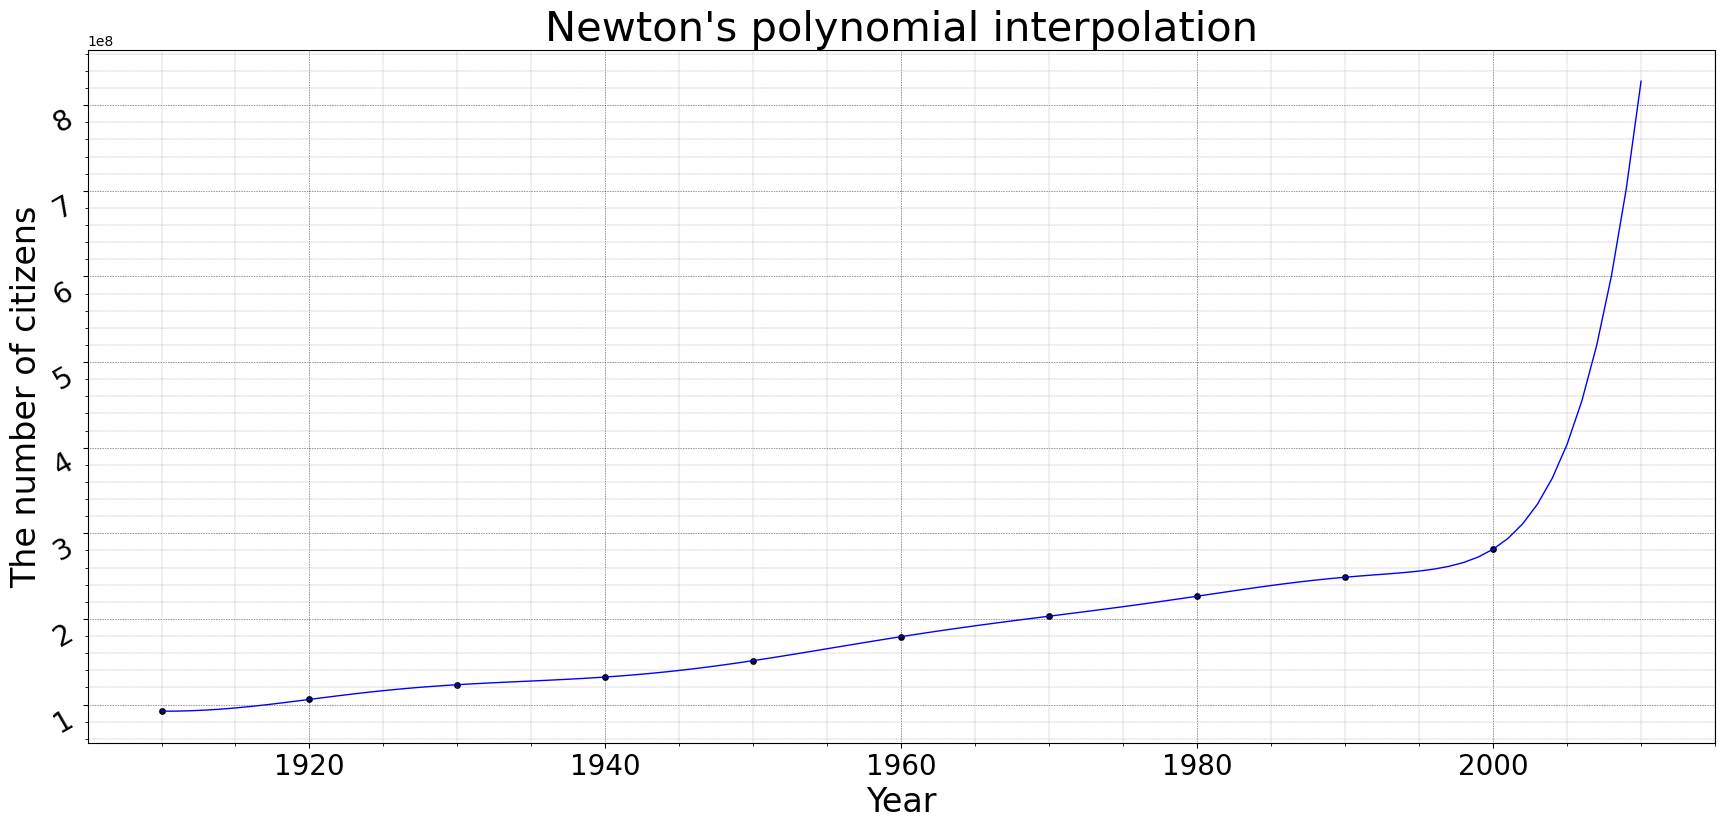

In [131]:
plt.figure(figsize = (21, 9), dpi = 100)
plt.title("Newton's polynomial interpolation", fontsize = 30)

plt.xlabel("Year", fontsize = 24)
plt.xticks(fontsize =  20, ha = "center", va = "top")

plt.ylabel("The number of citizens", fontsize = 24)
plt.yticks(fontsize = 20, rotation = 30, ha = "right", va = "top")

plt.scatter(years, souls, s = 15, color = "black")

step = 1
x = np.arange(years[0], years[len(years) - 1] + 10 + step, step)
poly = Newtons_Polynomial(years, souls)
plt.plot(x, poly(x), color='blue', linewidth = 1)

plt.grid (color = "black", linewidth = 0.45, linestyle = "dotted")
plt.minorticks_on()
plt.grid (which = "minor", color = "grey", linewidth = 0.25, linestyle = "dashed")

plt.show()

Extrapolation of the Newton's polynomial to the year 2010 gives the following unsatisfactory result:

In [132]:
n_souls_2010 = round(poly(2010))
# "n" stands for "Newton"

print(f"Extrapolated population of the USA in 2010 based on data from 1910 to 2000: {n_souls_2010}")
print(f"Actual population of the USA in 2010: {souls_2010}")

print(f"Relative error: {100 * abs(n_souls_2010 - souls_2010) / souls_2010:.1f}%")

Extrapolated population of the USA in 2010 based on data from 1910 to 2000: 827906509
Actual population of the USA in 2010: 308745538
Relative error: 168.2%


## Cubic spline

Let $x_i$, $i \in \{0, ..., N\}$, be points such that $x_0 < x_1 < ... < x_N$. Let also
$y_i$, $i \in \{0, ..., N\}$, be values of some function $F$ such that $F(x_i) = y_i$.

We wish to interpolate this data with a cubic spline. Let's introduce some notation:

\begin{equation*}
    S_i(x) = a_i + b_i(x - x_i) + c_i(x - x_i)^2 + d_i(x - x_i)^3,\ x \in [x_i; x_{i + 1}],\
    i \in \{0, ..., N - 1\}
\end{equation*}

\begin{equation*}
    h_i = x_{i + 1} - x_i,\ i \in \{0, ..., N - 1\}
\end{equation*}

Note that:

\begin{equation*}
    S_i(x_i) = a_i,\ i \in \{0, ..., N - 1\}
\end{equation*}

\begin{equation*}
    S'_i(x) = b_i + 2c_i(x - x_i) + 3d_i(x - x_i)^2 \implies S'_i(x_i) = b_i,\
    i \in \{0, ..., N - 1\}
\end{equation*}

\begin{equation*}
    S''_i(x) = 2c_i + 6d_i(x - x_i) \implies S''_i(x_i) = 2c_i,\ i \in \{0, ..., N - 1\}
\end{equation*}

By the definition of interpolation:
\begin{equation*}
    S_i(x_i) = y_i \implies \boxed{a_i = y_i,\ i \in \{0, ..., N - 1\}}
\end{equation*}

Coefficients $b_i$, $c_i$, $d_i$ can be found via solving the following system:
\begin{cases}
    S_{i - 1}(x_i) = S_i(x_i), i \in \{1, ..., N - 1\}\ \ \ (1)\\
    S'_{i - 1}(x_i) = S'_i(x_i), i \in \{1, ..., N - 1\}\ \ \ (2)\\
    S''_{i - 1}(x_i) = S''_i(x_i), i \in \{1, ..., N - 1\}\ \ \ (3)\\
    S_{N - 1}(x_N) = y_N\ \ \ (4)\\
    S''_0(x_0) = 0\ \ \ (5)\\
    S''_{N - 1}(x_N) = 0\ \ \ (6)
\end{cases}

Conditions (5) and (6) show that the resulting spline is so-called $\textit{natural spline}$.

Equation (5):

\begin{equation*}
    2c_0 = 0 \implies \boxed{c_0 = 0}
\end{equation*}

Equation (6):

\begin{equation*}
    2c_{N - 1} + 6d_{N - 1}(x_N - x_{N - 1}) = 0 \implies
    \boxed{d_{N - 1} = -\frac{c_{N - 1}}{3h_{N - 1}}}
\end{equation*}

Equations (3):

\begin{equation*}
    2c_{i - 1} + 6d_{i - 1}(x_i - x_{i - 1}) = 2c_i \implies
    c_i - c_{i - 1} = 3d_{i - 1}h_{i - 1} \implies
    d_{i - 1} = \frac{c_i - c_{i - 1}}{3h_{i - 1}},\ i \in \{1, ..., N - 1\}
\end{equation*}

\begin{equation*}
    \boxed{d_{i} = \frac{c_{i + 1} - c_i}{3h_i},\ i \in \{0, ..., N - 2\}}
\end{equation*}

Equation (4):

\begin{equation*}
    a_{N - 1} + b_{N - 1}(x_N - x_{N - 1}) + c_{N - 1}(x_N - x_{N - 1})^2 + d_{N - 1}(x_N - x_{N - 1})^3 = y_N
\end{equation*}

\begin{equation*}
    a_{N - 1} + b_{N - 1}h_{N - 1} + c_{N - 1}h_{N - 1}^2 - \frac{c_{N - 1}}{3h_{N - 1}}h_{N - 1}^3 = y_N
\end{equation*}

\begin{equation*}
    b_{N - 1}h_{N - 1} = y_N - y_{N - 1} - \frac{2c_{N - 1}}{3}h_{N - 1}^2
\end{equation*}

\begin{equation*}
    \boxed{b_{N - 1} = \frac{y_N - y_{N - 1}}{h_{N - 1}} - \frac{2c_{N - 1}}{3}h_{N - 1}}
\end{equation*}

Equations (1):

\begin{equation*}
    a_{i - 1} + b_{i - 1}(x_i - x_{i - 1}) + c_{i - 1}(x_i - x_{i - 1})^2 +
    d_{i - 1}(x_i - x_{i - 1})^3 = a_i
\end{equation*}

\begin{equation*}
    b_{i - 1}h_{i - 1} + c_{i - 1}h_{i - 1}^2 + d_{i - 1}h_{i - 1}^3 = a_i - a_{i - 1}
\end{equation*}

\begin{equation*}
    b_{i - 1}h_{i - 1} + c_{i - 1}h_{i - 1}^2 + \frac{c_i - c_{i - 1}}{3h_{i - 1}}h_{i - 1}^3 = a_i - a_{i - 1}
\end{equation*}

\begin{equation*}
    b_{i - 1}h_{i - 1} + \frac{c_i + 2c_{i - 1}}{3}h_{i - 1}^2 = a_i - a_{i - 1}
\end{equation*}

\begin{equation*}
    b_{i - 1} = \frac{a_i - a_{i - 1}}{h_{i - 1}} - \frac{c_i + 2c_{i - 1}}{3}h_{i - 1},\ i \in \{1, ..., N - 1\}
\end{equation*}

\begin{equation*}
    \boxed{b_i = \frac{y_{i + 1} - y_i}{h_i} - \frac{c_{i + 1} + 2c_i}{3}h_i,\
    i \in \{0, ..., N - 2\}}
\end{equation*}

Equations (2):

\begin{equation*}
    b_{i - 1} + 2c_{i - 1}(x_i - x_{i - 1}) + 3d_{i - 1}(x_i - x_{i - 1})^2 = b_i,\
    i \in \{1, ..., N - 1\}
\end{equation*}

$i \in \{1, ..., N - 2\}$:

\begin{equation*}
    \frac{y_i - y_{i - 1}}{h_{i - 1}} - \frac{c_i + 2c_{i - 1}}{3}h_{i - 1} + 2c_{i - 1}h_{i - 1} +
    3\frac{c_i - c_{i - 1}}{3h_{i - 1}}h_{i - 1}^2 =
    \frac{y_{i + 1} - y_i}{h_i} - \frac{c_{i + 1} + 2c_i}{3}h_i
\end{equation*}

\begin{equation*}
    \frac{c_{i + 1} + 2c_i}{3}h_i - \frac{c_i + 2c_{i - 1}}{3}h_{i - 1} + (c_i + c_{i - 1})h_{i - 1} =
    \frac{y_{i + 1} - y_i}{h_i} - \frac{y_i - y_{i - 1}}{h_{i - 1}}
\end{equation*}

\begin{equation*}
    (c_{i + 1} + 2c_i)h_i - (c_i + 2c_{i - 1})h_{i - 1} + 3(c_i + c_{i - 1})h_{i - 1} =
    3\left(\frac{y_{i + 1} - y_i}{h_i} - \frac{y_i - y_{i - 1}}{h_{i - 1}}\right)
\end{equation*}

\begin{equation*}
    \boxed{h_{i - 1}c_{i - 1} + 2(h_{i - 1} + h_i)c_i + h_ic_{i + 1} =
    3\left(\frac{y_{i + 1} - y_i}{h_i} - \frac{y_i - y_{i - 1}}{h_{i - 1}}\right),\
    i \in \{1, ..., N - 2\}}
\end{equation*}

$i = N - 1$:

\begin{equation*}
    \frac{y_{N - 1} - y_{N - 2}}{h_{N - 2}} - \frac{c_{N - 1} + 2c_{N - 2}}{3}h_{N - 2}
     + 2c_{N - 2}h_{N - 2} + 3\frac{c_{N - 1} - c_{N - 2}}{3h_{N - 2}}h_{N - 2}^2 =
    \frac{y_N - y_{N - 1}}{h_{N - 1}} - \frac{2c_{N - 1}}{3}h_{N - 1}
\end{equation*}

\begin{equation*}
    (c_{N - 1} + c_{N - 2})h_{N - 2} - \frac{c_{N - 1} + 2c_{N - 2}}{3}h_{N - 2} +
    \frac{2c_{N - 1}}{3}h_{N - 1} =
    \frac{y_N - y_{N - 1}}{h_{N - 1}} - \frac{y_{N - 1} - y_{N - 2}}{h_{N - 2}}
\end{equation*}

\begin{equation*}
    3(c_{N - 1} + c_{N - 2})h_{N - 2} - (c_{N - 1} + 2c_{N - 2})h_{N - 2} + 2c_{N - 1}h_{N - 1} =
    3\left(\frac{y_N - y_{N - 1}}{h_{N - 1}} - \frac{y_{N - 1} - y_{N - 2}}{h_{N - 2}}\right)
\end{equation*}

\begin{equation*}
    \boxed{h_{N - 2}c_{N - 2} + 2(h_{N - 2} + h_{N - 1})c_{N - 1} =
    3\left(\frac{y_N - y_{N - 1}}{h_{N - 1}} - \frac{y_{N - 1} - y_{N - 2}}{h_{N - 2}}\right)}
\end{equation*}

So we have a system:

\begin{equation*}
    \begin{pmatrix}
        2(h_0 + h_1) & h_1          & ... & 0                        & 0 \\
        h_1          & 2(h_1 + h_2) & ... & 0                        & 0 \\
        ...          & ...          & ... & ...                      & ...\\
        0            & 0            & ... & 2(h_{N - 3} + h_{N - 2}) & h_{N - 2} \\
        0            & 0            & ... & h_{N - 2}                & 2(h_{N - 2} + h_{N - 1})
    \end{pmatrix}
    \begin{pmatrix}
        c_1 \\
        c_2 \\
        ... \\
        c_{N - 2} \\
        c_{N - 1} \\
    \end{pmatrix} =
    3\begin{pmatrix}
        \frac{y_2 - y_1}{h_1} - \frac{y_1 - y_0}{h_0} \\
        \frac{y_3 - y_2}{h_2}  - \frac{y_2 - y_1}{h_1} \\
        ... \\
        \frac{y_{N - 1} - y_{N - 2}}{h_{N - 2}}  - \frac{y_{N - 2} - y_{N - 3}}{h_{N - 3}} \\
        \frac{y_N - y_{N - 1}}{h_{N - 1}}  - \frac{y_{N - 1} - y_{N - 2}}{h_{N - 2}}
    \end{pmatrix}
\end{equation*}

Solving the system will provide us with $c_1$, ..., $c_{N - 1}$; we already know that $c_0 = 0$.
Thus, we can find $b_i$ and $d_i$, $i \in \{0, ..., N - 1\}$ by the formulas presented above.

In [133]:
def tridiagonal_matrix_algorithm(A, f):

    dim = A.shape[0]
    r = np.empty(dim - 1)
    p = np.empty(dim - 1)

    r[0] = f[0] / A[0, 0]
    p[0] = A[0, 1] / A[0, 0]
    for i in range(1, dim - 1):
        a_i = A[i, i - 1]
        b_i = A[i, i]
        c_i = A[i, i + 1]
        r[i] = (f[i] - a_i * r[i - 1]) / (b_i - a_i * p[i - 1])
        p[i] = c_i / (b_i - a_i * p[i - 1])

    a_n = A[dim - 1, dim - 2]
    b_n = A[dim - 1, dim - 1]
    x = np.empty(dim)
    x[dim - 1] = (f[dim - 1] - a_n * r[dim - 2]) / (b_n - a_n * p[dim - 2])
    for i in range(dim - 2, -1, -1):
        x[i] = r[i] - p[i] * x[i + 1]

    return x

class Cubic_Spline:

    def __init__(self, x, y):

        self.N = len(x) - 1
        if self.N < 3:
            raise RuntimeError("Not enough points for cubic spline")

        self._x = x.copy()
        self._y = y.copy()

        self._coeffs = np.empty((3, self.N))
        self._compute_c_coeffs()
        self._compute_b_coeffs()
        self._compute_d_coeffs()

    def __call__(self, x):

        if x < self._x[0]:
            spline_i = 0
        if x > self._x[self.N]:
            spline_i = self.N - 1
        else:
            for i in range(self.N + 1):
                if self._x[i] <= x and x <= self._x[i + 1]:
                    spline_i = i
                    break

        dx = x - self._x[spline_i]
        a = self._y[spline_i]
        b = self._coeffs[0, spline_i]
        c = self._coeffs[1, spline_i]
        d = self._coeffs[2, spline_i]

        return a + b * dx + c * (dx ** 2) + d * (dx ** 3)

    def _compute_matrix(self):

        if self.N < 3:
            raise RuntimeError("Not enough points for cubic spline")

        A = np.zeros((self.N - 1, self.N - 1))

        A[0, 0] = 2 * (self._x[2] - self._x[0])
        A[0, 1] = self._x[2] - self._x[1]

        for i in range(1, self.N - 2):
            A[i, i - 1] = self._x[i + 1] - self._x[i]
            A[i, i] = 2 * (self._x[i + 2] - self._x[i])
            A[i, i + 1] = self._x[i + 2] - self._x[i + 1]

        A[self.N - 2, self.N - 3] = self._x[self.N - 1] - self._x[self.N - 2]
        A[self.N - 2, self.N - 2] = 2 * (self._x[self.N] - self._x[self.N - 2])

        return A

    def _div_diff(self, i):
        return (self._y[i + 1] - self._y[i]) / (self._x[i + 1] - self._x[i])

    def _compute_free_coeffs(self):

        b = np.empty(self.N - 1)

        for i in range(self.N - 1):
            b[i] = 3 * (self._div_diff(i + 1) - self._div_diff(i))

        return b


    def _compute_c_coeffs(self):

        A = self._compute_matrix()
        b = self._compute_free_coeffs()

        c = tridiagonal_matrix_algorithm(A, b)

        self._coeffs[1] = np.insert(c, 0, 0)

    def _compute_b_coeffs(self):

        for i in range(self.N - 1):

            c_i = self._coeffs[1, i]
            c_i_plus_1 = self._coeffs[1, i + 1]
            h_i = self._x[i + 1] - self._x[i]

            self._coeffs[0, i] = self._div_diff(i) - (c_i_plus_1 + 2 * c_i) * h_i / 3

        c_N_minus_1 = self._coeffs[1, self.N - 1]
        h_N_minus_1 = self._x[self.N] - self._x[self.N - 1]
        self._coeffs[0, self.N - 1] = self._div_diff(self.N - 1) - 2 * c_N_minus_1 * h_N_minus_1 / 3

    def _compute_d_coeffs(self):

        for i in range(self.N - 1):

            c_i = self._coeffs[1, i]
            c_i_plus_1 = self._coeffs[1, i + 1]
            h_i = self._x[i + 1] - self._x[i]

            self._coeffs[2, i] = (c_i_plus_1 - c_i) / (3 * h_i)

        c_N_minus_1 = self._coeffs[1, self.N - 1]
        h_N_minus_1 = self._x[self.N] - self._x[self.N - 1]
        self._coeffs[2, self.N - 1] = -c_N_minus_1 / (3 * h_N_minus_1)

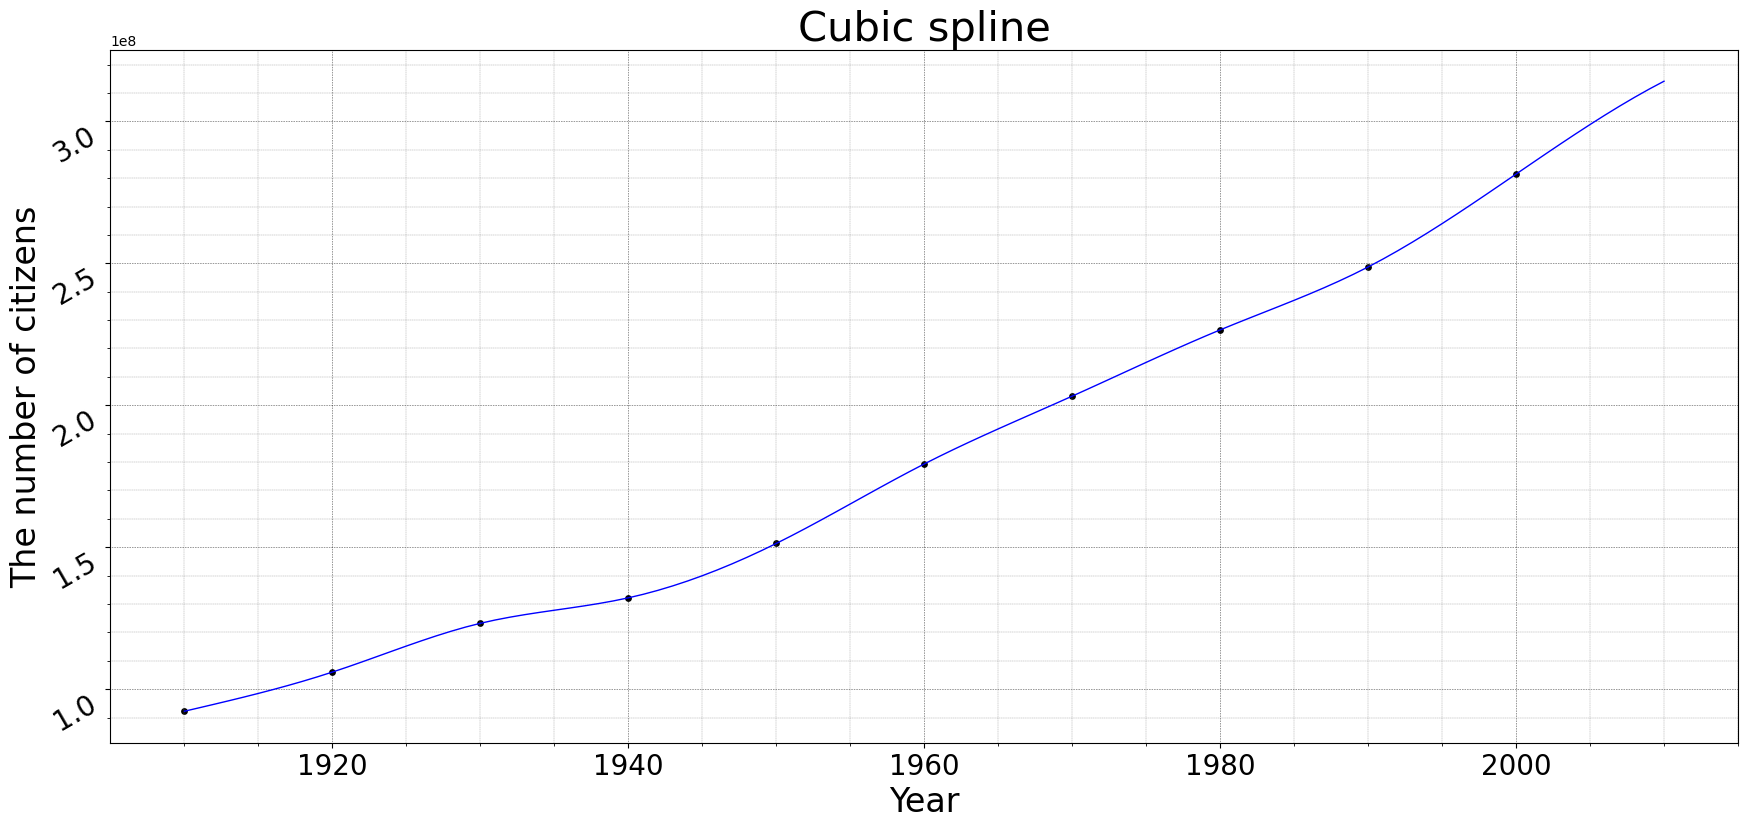

In [134]:
plt.figure(figsize = (21, 9), dpi = 100)
plt.title("Cubic spline", fontsize = 30)

plt.xlabel("Year", fontsize = 24)
plt.xticks(fontsize =  20, ha = "center", va = "top")

plt.ylabel("The number of citizens", fontsize = 24)
plt.yticks(fontsize = 20, rotation = 30, ha = "right", va = "top")

plt.scatter(years, souls, s = 15, color = "black")

step = 1
x = np.arange(years[0], years[len(years) - 1] + 10 + step, step)
cs = Cubic_Spline(years, souls)
y = []
for point in x:
    y.append(cs(point))
plt.plot(x, y, color='blue', linewidth = 1)

plt.grid (color = "black", linewidth = 0.45, linestyle = "dotted")
plt.minorticks_on()
plt.grid (which = "minor", color = "grey", linewidth = 0.25, linestyle = "dashed")

Extrapolation of the cubic spline to the year 2010 gives the following result:

In [135]:
s_souls_2010 = round(cs(2010))
# "s" stands for "spline"

print(f"Extrapolated population of the USA in 2010 based on data from 1910 to 2000: {s_souls_2010}")
print(f"Actual population of the USA in 2010: {souls_2010}")

print(f"Relative error: {100 * abs(s_souls_2010 - souls_2010) / souls_2010:.1f}%")

Extrapolated population of the USA in 2010 based on data from 1910 to 2000: 314133939
Actual population of the USA in 2010: 308745538
Relative error: 1.7%


## Conclusion

Method of the least squares happened to provide us with the smallest relative error of extrapolated
population of the USA.